# Simulator runner

In [12]:
import matplotlib.pyplot as plt
%matplotlib notebook
from collections import defaultdict

In [2]:
from utilitysimv2 import Camera, InferenceJob, TrainingJob, MultiPeriodSimulator, fair_naive_scheduler, fair_sco_scheduler, fair_random_scheduler, inference_only_scheduler, single_camera_naive, get_optimus_fn, thief_sco_scheduler, single_camera_optimizer, get_tanh_fn, get_linear_fn, get_tanh_fn, simulator, thief_scheduler, fair_scheduler

In [3]:
train_profiles = [
(68.00, 100.92, 0),
(72.00, 51.14, 0),
(75.20, 74.22, 0),
(83.10, 207.44, 0),
(64.70, 17.91, 0),
(87.00, 100.30, 0),
(70.50, 68.04, 0),
(60.90, 26.22, 0),
(58.60, 97.26, 0),
(59.50, 21.76, 0),
(69.80, 44.00, 0),
(68.00, 49.59, 0),
(73.00, 219.19, 0),
(77.80, 125.70, 0),
(62.80, 64.54, 0),
(67.90, 53.29, 0),
(69.20, 23.23, 0),
(84.60, 201.70, 0),
(83.50, 211.34, 0),
(61.10, 18.02, 0),
(69.30, 24.61, 0),
(63.80, 26.49, 0),
(56.20, 16.38, 0),
(64.60, 19.09, 0),
(65.20, 46.56, 0),
(76.70, 30.91, 0),
(69.50, 52.43, 0),
(58.30, 25.39, 0),
(75.20, 34.01, 0),
(63.30, 40.14, 0),
(68.70, 48.39, 0),
(77.40, 108.93, 0),
(84.00, 186.64, 0),
(70.20, 39.01, 0),
(65.60, 28.55, 0),
(50.20, 15.00, 0),
(86.50, 110.82, 0),
(56.30, 53.75, 0),
(58.70, 38.64, 0),
(53.80, 33.42, 0),
(74.50, 269.82, 0),
(74.80, 87.55, 0),
(78.00, 50.23, 0),
(54.80, 19.12, 0),
(86.30, 125.32, 0),
(57.30, 31.06, 0),
(75.30, 78.57, 0),
(76.80, 141.83, 0),
(79.80, 200.14, 0),
(65.50, 28.08, 0),
(75.90, 70.68, 0),
(81.30, 65.21, 0),
(52.10, 21.93, 0),
(75.60, 29.03, 0),
(59.40, 38.94, 0),
(67.60, 137.32, 0),
(65.80, 21.98, 0),
(77.20, 69.87, 0),
(69.10, 22.27, 0),
(59.90, 37.97, 0),
(74.20, 80.85, 0),
(63.10, 33.06, 0),
(60.10, 17.07, 0),
(54.00, 15.59, 0),
(52.20, 56.11, 0),
(86.60, 367.83, 0),
(70.00, 36.71, 0),
(85.10, 112.62, 0),
(70.60, 33.53, 0),
(61.50, 36.86, 0),
(57.60, 16.92, 0),
(77.00, 54.99, 0),
(64.90, 19.71, 0),
(79.00, 77.27, 0),
(70.60, 31.76, 0),
(61.10, 19.18, 0),
(69.50, 20.81, 0),
(57.80, 14.16, 0),
(64.40, 48.67, 0),
(61.40, 21.29, 0),
(61.70, 20.47, 0),
(66.60, 23.37, 0),
(55.80, 42.05, 0),
(54.90, 18.05, 0),
(79.80, 114.54, 0),
(58.50, 52.74, 0),
(59.30, 20.81, 0),
(63.00, 25.47, 0),
(62.00, 42.15, 0),
(75.80, 120.19, 0),
(67.30, 42.25, 0),
(60.80, 58.24, 0),
(70.50, 148.33, 0),
(73.00, 30.98, 0),
(79.50, 121.01, 0),
(71.70, 33.71, 0),
(60.00, 33.52, 0),
(71.70, 57.51, 0),
(78.10, 30.76, 0),
(77.40, 87.95, 0),
(82.60, 222.61, 0),
(65.60, 39.37, 0),
(62.90, 26.53, 0),
(80.60, 236.74, 0),
(51.40, 31.29, 0),
(80.20, 125.89, 0),
(63.50, 22.59, 0),
(57.70, 34.40, 0),
(72.00, 170.99, 0),
(80.70, 415.04, 0),
(60.20, 31.56, 0),
]

In [4]:
def create_cameras(n, start_accuracy = 40):
    cameras = [] 
    profiles_per_camera = int(len(train_profiles)/n)
    for i in range(0, n):
        cameras.append(Camera(str(i),
               train_profiles[i*profiles_per_camera:(i+1)*profiles_per_camera],
               start_accuracy))
    return cameras

## Run comparison

In [16]:
data = defaultdict(dict)
allocation = defaultdict(dict)
resources_to_test = [1,2,3,4,5,6,7,8,9,10]
n_cameras = 2
num_periods = 3
start_accuracy = 40
retraining_period = 400

schedulers_to_test = [(fair_random_scheduler, 'fair_random'),
                      (fair_naive_scheduler, 'fair_naive'),
                     (fair_sco_scheduler, 'fair_sco'),
                     (lambda x,y,z: thief_sco_scheduler(x,y,z,iterations=5), 'thief'),
                     (inference_only_scheduler, 'inference_only')
                     ]

for provisioned_res in resources_to_test:
    print("Resources: {}".format(provisioned_res))
    for scheduler, sched_name in schedulers_to_test:
        cameras = create_cameras(n_cameras, start_accuracy)
        mps = MultiPeriodSimulator(cameras, provisioned_res, scheduler, retraining_period, num_periods = num_periods)
        results, period_allocation_log = mps.step_till_completion()
        data[provisioned_res][sched_name] = results['meta']['overall_inf_mean_auc']
        allocation[provisioned_res][sched_name] = period_allocation_log

        
for provisioned_res in resources_to_test:
    cameras = create_cameras(n_cameras, start_accuracy)
    scheduler, sched_name = lambda x,y,z: thief_sco_scheduler(x,y,z,iterations=5), "thief_longwindow"
    mps = MultiPeriodSimulator(cameras, provisioned_res, scheduler, retraining_period*num_periods, num_periods = 1)
    results, period_allocation_log = mps.step_till_completion()
    data[provisioned_res][sched_name] = results['meta']['overall_inf_mean_auc']
    allocation[provisioned_res][sched_name] = period_allocation_log

50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_

Resources: 1
Running period 0
Running period 1
Running period 2
Running period 0


Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 i

Running period 1
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 2
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 0


50
100
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_tra

Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
300
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_

Running period 1


Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
250
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_

Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
350
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_51 is done.
Job 0_train_

Running period 2
Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.25, 0.25], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.25, 0.25]}


Best config for 0_inference: 0_train_53
Best config for 1_inference: 1_train_43
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.04999999999999999, 0.45], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.04999999999999999, 0.45]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.04999999999999999, 0.45], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.04999999999999999, 0.45]}
Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_train_43
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.04999999999999999, 0.35], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.04999999999999999, 0.55]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.04999999999999999, 0.35], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.04999999999999999, 0.55]}
Best config for 0_inference: 0_train_53
Best config for 1_inference: 1_train_43
Iter 2, final_alloc:

50
Job 0_train_53 is done.
Job 0_train_53 is done.
Job 0_train_53 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_5

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.04999999999999999, 0.45], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.04999999999999999, 0.45]}


Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 i

Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 i

Running period 1
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.25, 0.25], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.25, 0.25]}
Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_train_18


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.04999999999999993, 0.04999999999999999], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.8500000000000001, 0.04999999999999999]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.04999999999999993, 0.04999999999999999], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.8500000000000001, 0.04999999999999999]}
Best config for 0_inference: 0_train_3
Best config for 1_inference: 1_train_10
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.04999999999999993, 0.04999999999999999], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.8500000000000001, 0.04999999999999999]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.04999999999999993, 0.04999999999999999], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.8500000000000001, 0.04999999999999999]}
Best config for 0_inference: 0_train_3
Best config for 1_inferenc

50
100
150
200
250
300
350
400
Simulator steps done.


Best config for 0_inference: 0_train_3
Best config for 1_inference: 1_train_10
Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.04999999999999993, 0.04999999999999999], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.8500000000000001, 0.04999999999999999]}
Running period 2
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.25, 0.25], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.25, 0.25]}


Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_train_18
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.04999999999999993, 0.04999999999999999], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.8500000000000001, 0.04999999999999999]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.04999999999999993, 0.04999999999999999], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.8500000000000001, 0.04999999999999999]}
Best config for 0_inference: 0_train_3
Best config for 1_inference: 1_train_10
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.04999999999999993, 0.04999999999999999], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.8500000000000001, 0.04999999999999999]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.04999999999999993, 0.04999999999999999], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.8500000000000001, 0.04999

50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
Job 0_train_0 is done.


Best config for 1_inference: 1_train_10
Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bfef0>: [0.04999999999999993, 0.04999999999999999], <utilitysimv2.InferenceJob object at 0x7ffb4103dc50>: [0.8500000000000001, 0.04999999999999999]}
Running period 0
Running period 1
Running period 2
Resources: 2
Running period 0


Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train

Job 0_train_1 is done.
Job 0_train_1 is done.
Job 0_train_1 is done.
Job 0_train_1 is done.
Job 0_train_1 is done.
Job 0_train_1 is done.
Job 0_train_1 is done.
Job 0_train_1 is done.
Job 0_train_1 is done.
Job 0_train_1 is done.
Job 0_train_1 is done.
Job 0_train_1 is done.
Job 0_train_1 is done.
Job 0_train_1 is done.
Job 0_train_1 is done.
Job 0_train_1 is done.
Job 0_train_1 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train

Running period 1


Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train

Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0_train

Running period 2
Running period 0


Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
400
Job 0_train_5 is done.
Job 1_train_12 is done.
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.


Running period 1
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 2
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 0


50
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
100
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_tra

Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
300
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_tra

Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.


Running period 1


Job 1_train_12 is done.
300
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_

Running period 2
Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.5]}


Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_train_43
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.5]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.5]}
Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_train_43
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.5]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.5]}
Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_train_43
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.5]}
It

50
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_4

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.5]}


Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
200
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_

Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 i

Running period 1
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.5]}
Best config for 0_inference: 0_train_42
Best config for 1_inference: 1_train_18


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.6], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.4]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.6], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.4]}
Best config for 0_inference: 0_train_42
Best config for 1_inference: 1_train_18
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.6], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.4]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.6], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.4]}
Best config for 0_inference: 0_train_42
Best config for 1_inference: 1_train_18
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.6], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.4]}
Iter 3, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.6], 

50
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
100
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_train_42 is done.
Job 0_tra

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.6], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.4]}


Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 i

Job 1_train_18 is done.
Job 0_train_42 is done.
Job 1_train_18 is done.
Job 0_train_42 is done.
400
Job 1_train_18 is done.
Job 0_train_42 is done.
Simulator steps done.


Running period 2
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.5]}
Best config for 0_inference: 0_train_51
Best config for 1_inference: 1_train_12


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.3], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.7]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.3], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.7]}
Best config for 0_inference: 0_train_51
Best config for 1_inference: 1_train_12
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.3], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.7]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.3], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.7]}
Best config for 0_inference: 0_train_51
Best config for 1_inference: 1_train_12
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.3], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.7]}
Iter 3, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.3], 

50
100
150
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.5, 0.3], <utilitysimv2.InferenceJob object at 0x7ffb3a4d6a58>: [0.5, 0.7]}


Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 is done.
Job 0_train_51 is done.
Job 1_train_12 i

Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
250
Job 0_t

Running period 0
Running period 1
Running period 2
Resources: 3
Running period 0


Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
350
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_t

Running period 1


200
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_t

Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train

Running period 2


Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
200
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_t

Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train

Running period 0


Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
250
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_tra

Running period 1
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 2
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 0


50
100
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
150
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_tr

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Running period 1
Running period 2
Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [0.75, 0.75], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [0.75, 0.75]}


Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_train_43
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [0.35000000000000003, 1.85], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [0.04999999999999993, 0.75]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [0.35000000000000003, 1.85], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [0.04999999999999993, 0.75]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_43
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [0.04999999999999993, 1.1500000000000001], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [0.55, 1.25]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [0.04999999999999993, 1.1500000000000001], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [0.55, 1.25]}
Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_train_43
Iter 2, final_alloc: {<

Job 0_train_25 is done.
Job 0_train_25 is done.
Job 0_train_25 is done.
Job 0_train_25 is done.
Job 0_train_25 is done.
Job 0_train_25 is done.
Job 0_train_25 is done.
Job 0_train_25 is done.
Job 0_train_25 is done.
Job 0_train_25 is done.
Job 0_train_25 is done.
Job 0_train_25 is done.
Job 0_train_25 is done.
Job 0_train_25 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 i

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [0.35000000000000003, 1.85], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [0.04999999999999993, 0.75]}


Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
150
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_

Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 i

Running period 1
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [0.75, 0.75], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [0.75, 0.75]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [1.05, 0.75], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [1.05, 0.1499999999999999]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [1.05, 0.75], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [1.05, 0.1499999999999999]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_10
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [1.05, 0.8500000000000001], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [1.05, 0.04999999999999993]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [1.05, 0.8500000000000001], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [1.05, 0.04999999999999993]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_10
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [1.05, 0.8500000000000001], <utilitysimv2.InferenceJob objec

50
100
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
150
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.


Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [1.05, 0.8500000000000001], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [1.05, 0.04999999999999993]}


Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
400
Job 0_train_5 is done.
Simulator steps done.


Running period 2
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [0.75, 0.75], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [0.75, 0.75]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_12


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [1.0, 1.0]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [1.0, 1.0]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_12
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [1.0, 1.0]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [1.0, 1.0]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_12
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [1.0, 1.0]}
Iter 3, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [1.0, 0], <utilitysimv2.InferenceJ

50
100
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
150
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4bf6d8>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103dac8>: [1.0, 1.0]}
Running period 0
Running period 1
Running period 2
Resources: 4
Running period 0


Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train

Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
300
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_t

Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
150
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_t

Running period 1


Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train

Job 0_train_1 is done.
350
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_t

Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_1

Running period 2


Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
350
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_tra

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.


Running period 0


Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
350
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_t

Running period 1
No job found to fit in the retraining window. Not retraining this period.
Running period 2
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 0


50
100
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
300
Job 0_tra

Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
400
Job 1_train_10 is done.
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.


Running period 1
Running period 2
Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [1.0, 1.0], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [1.0, 1.0]}


Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_43
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [0.4, 1.1999999999999997], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [0.5, 1.9000000000000004]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [0.4, 1.1999999999999997], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [0.5, 1.9000000000000004]}
Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_train_43
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [0.0, 0.8], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [0.0, 3.2]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [0.0, 0.8], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [0.0, 3.2]}
Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_train_12
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [0.3999999999999999, 

Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 i

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [0.0, 0.8], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [0.0, 3.2]}


Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
150
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_

Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 i

Running period 1
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [1.0, 1.0], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [1.0, 1.0]}
Best config for 0_inference: 0_train_5


Best config for 1_inference: 1_train_12
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [1.0, 1.5], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [1.0, 0.5]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [1.0, 1.5], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [1.0, 0.5]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [1.0, 1.5], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [1.0, 0.5]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [1.0, 1.5], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [1.0, 0.5]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [1.0, 1.5], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [1.0, 0.5]}
Iter 3, alloc: {<utilitysimv2.InferenceJob o

50
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
100
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [1.0, 1.5], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [1.0, 0.5]}


Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_1

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
400
Job 0_train_5 is done.
Job 1_train_12 is done.
Simulator steps done.


Running period 2
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [1.0, 1.0], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [1.0, 1.0]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [1.0333333333333332, 0], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [1.0333333333333332, 1.9333333333333333]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [1.0333333333333332, 0], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [1.0333333333333332, 1.9333333333333333]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [1.0333333333333332, 0], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [1.0333333333333332, 1.9333333333333333]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [1.0333333333333332, 0], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [1.0333333333333332, 1.9333333333333333]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: 

50
100
150
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
200
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
J

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a76c630>: [1.0333333333333332, 0], <utilitysimv2.InferenceJob object at 0x7ffb3a5f8b70>: [1.0333333333333332, 1.9333333333333333]}
Running period 0
Running period 1
Running period 2
Resources: 5
Running period 0


Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train

Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
300
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_t

Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train

Running period 1


Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train

Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
400
Job 0_train_1 is done.
Job 1_train_2 is done.
Simulator steps done.
50
Job 0_train_2 is done.
Job 0_train_2 is done.
Job 0

Running period 2


Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
200
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_t

Running period 0


Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_1

Running period 1
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 2
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 0


50
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
100
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_trai

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_1

Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
300
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_

Running period 1
Running period 2
Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [1.25, 1.25], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [1.25, 1.25]}


Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_43
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [0.14999999999999986, 1.65], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [0.4499999999999999, 2.7500000000000004]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [0.14999999999999986, 1.65], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [0.4499999999999999, 2.7500000000000004]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [0.049999999999999906, 3.7500000000000004], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [0.049999999999999906, 1.1500000000000001]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [0.049999999999999906, 3.7500000000000004], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [0.049999999999999906, 1.1500000000000001]}
Best config for 

Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is don

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [0.14999999999999986, 1.65], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [0.4499999999999999, 2.7500000000000004]}


Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
150
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_tra

Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5

Running period 1
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [1.25, 1.25], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [1.25, 1.25]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_12


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [1.0666666666666667, 0], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [1.0666666666666667, 2.8666666666666667]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [1.0666666666666667, 0], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [1.0666666666666667, 2.8666666666666667]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_12
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [1.0666666666666667, 0], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [1.0666666666666667, 2.8666666666666667]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [1.0666666666666667, 0], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [1.0666666666666667, 2.8666666666666667]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_12
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: 

Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
50
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_1

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [1.0666666666666667, 0], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [1.0666666666666667, 2.8666666666666667]}


Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
250
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_

Running period 2
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [1.25, 1.25], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [1.25, 1.25]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [1.0666666666666667, 0], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [1.0666666666666667, 2.8666666666666667]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [1.0666666666666667, 0], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [1.0666666666666667, 2.8666666666666667]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [1.0666666666666667, 0], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [1.0666666666666667, 2.8666666666666667]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [1.0666666666666667, 0], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [1.0666666666666667, 2.8666666666666667]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: 

50
100
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
150
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40265c18>: [1.0666666666666667, 0], <utilitysimv2.InferenceJob object at 0x7ffb40265da0>: [1.0666666666666667, 2.8666666666666667]}


Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
350
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_

Running period 0
Running period 1
Running period 2
Resources: 6
Running period 0


Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train

Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
300
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_t

Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
100
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_t

Running period 1


Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train

Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
350
Job 1_train_2 is done.
Job 0_t

Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.


Running period 2


Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
250
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_tra

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
100
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_t

Running period 0


Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_1

Running period 1
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 2
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 0


50
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
250
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_tra

Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
250
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_

Running period 1
Running period 2
Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [1.5, 1.5], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [1.5, 1.5]}


Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [1.0, 2.5], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [1.0, 1.5]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [1.0, 2.5], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [1.0, 1.5]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [1.0, 2.5], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [1.0, 1.5]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [1.0, 2.5], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [1.0, 1.5]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [1.0, 2.5], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [1.0, 1.5]}
Iter 

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
50
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is don

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [1.0, 2.5], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [1.0, 1.5]}


Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
150
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_tra

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Running period 1
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [1.5, 1.5], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [1.5, 1.5]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [1.0, 4.0]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [1.0, 4.0]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [1.0, 4.0]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [1.0, 4.0]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [1.0, 4.0]}
Iter 3, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [1.0, 0], <utilitysimv2.InferenceJ

50
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
100
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_tra

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [1.0, 4.0]}


Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
300
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_

Running period 2
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [1.5, 1.5], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [1.5, 1.5]}
Best config for 0_inference: None
Best config for 1_inference: None


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [3.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [3.0, 0]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [3.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [3.0, 0]}
Best config for 0_inference: None
Best config for 1_inference: None
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [3.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [3.0, 0]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [3.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [3.0, 0]}
Best config for 0_inference: None
Best config for 1_inference: None
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [3.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [3.0, 0]}
Iter 3, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [3.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb40f

50
100
150
200
250
300
350
400
Simulator steps done.
50
100


Iter 3, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [3.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [3.0, 0]}
Iter 4, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [3.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [3.0, 0]}
Best config for 0_inference: None
Best config for 1_inference: None
Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb40fed5f8>: [3.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb40fed080>: [3.0, 0]}
Running period 0


150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is 

Running period 1
Running period 2
Resources: 7
Running period 0


Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train

Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
350
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_t

Running period 1


Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
150
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_t

Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train

Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
200
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_tra

Running period 2


Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2

Job 1_train_10 is done.
400
Job 0_train_2 is done.
Job 1_train_10 is done.
Simulator steps done.
50
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job

Running period 0


Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
250
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_t

Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.


Running period 1
No job found to fit in the retraining window. Not retraining this period.


Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
350
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_

Running period 2
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 0


50
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
250
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_tra

Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
200
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_

Running period 1


Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
400
Job 1_train_10 is done.
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.


Running period 2
Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [1.75, 1.75], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [1.75, 1.75]}


Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [0.95, 3.45], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [0.95, 1.6500000000000001]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [0.95, 3.45], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [0.95, 1.6500000000000001]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [0.95, 3.45], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [0.95, 1.6500000000000001]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [0.95, 3.45], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [0.95, 1.6500000000000001]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [0.95, 3.45

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
50
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [0.95, 3.45], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [0.95, 1.6500000000000001]}


Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
150
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_tra

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Running period 1
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [1.75, 1.75], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [1.75, 1.75]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [1.0333333333333334, 0], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [1.0333333333333334, 4.933333333333334]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [1.0333333333333334, 0], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [1.0333333333333334, 4.933333333333334]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [1.0333333333333334, 0], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [1.0333333333333334, 4.933333333333334]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [1.0333333333333334, 0], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [1.0333333333333334, 4.933333333333334]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [1.0

50
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
100
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_tra

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [1.0333333333333334, 0], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [1.0333333333333334, 4.933333333333334]}
Running period 2
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [1.75, 1.75], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [1.75, 1.75]}
Best config for 0_inference: None
Best config for 1_inference: None


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [3.5, 0], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [3.5, 0]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [3.5, 0], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [3.5, 0]}
Best config for 0_inference: None
Best config for 1_inference: None
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [3.5, 0], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [3.5, 0]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [3.5, 0], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [3.5, 0]}
Best config for 0_inference: None
Best config for 1_inference: None
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [3.5, 0], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [3.5, 0]}
Iter 3, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [3.5, 0], <utilitysimv2.InferenceJob object at 0x7ffb3a4

50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4a4208>: [3.5, 0], <utilitysimv2.InferenceJob object at 0x7ffb3a4a4240>: [3.5, 0]}
Running period 0
Running period 1
Running period 2
Resources: 8
Running period 0


Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
150
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_t

Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train

Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train

Running period 1


Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train

Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
350
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_t

200
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_tra

Running period 2


Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
250
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_tra

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
100
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_t

Running period 0


Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_1

Job 1_train_10 is done.
Job 0_train_5 is done.
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.


Running period 1
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 2
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 0


50
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 0_train_5 is done.
Simulator steps done.
50
100
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
150
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_tr

Running period 1


Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
350
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_

Running period 2
Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [2.0, 2.0], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [2.0, 2.0]}


Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [1.0, 3.5999999999999996], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [0.9999999999999999, 2.4]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [1.0, 3.5999999999999996], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [0.9999999999999999, 2.4]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [1.0, 3.5999999999999996], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [0.9999999999999999, 2.4]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [1.0, 3.5999999999999996], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [0.9999999999999999, 2.4]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 2, final_alloc: {<utilitysimv2.Inf

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
50
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [1.0, 3.5999999999999996], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [0.9999999999999999, 2.4]}


Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
150
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_tra

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_1

Running period 1
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [2.0, 2.0], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [2.0, 2.0]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [1.0666666666666664, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [1.0666666666666664, 5.866666666666667]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [1.0666666666666664, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [1.0666666666666664, 5.866666666666667]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [1.0666666666666664, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [1.0666666666666664, 5.866666666666667]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [1.0666666666666664, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [1.0666666666666664, 5.866666666666667]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [1.0

50
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
100
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_tra

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [1.0666666666666664, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [1.0666666666666664, 5.866666666666667]}


Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
350
Job 1_train_10 is done.
Job 1_train_

Running period 2
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [2.0, 2.0], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [2.0, 2.0]}
Best config for 0_inference: None
Best config for 1_inference: None


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [4.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [4.0, 0]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [4.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [4.0, 0]}
Best config for 0_inference: None
Best config for 1_inference: None
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [4.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [4.0, 0]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [4.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [4.0, 0]}
Best config for 0_inference: None
Best config for 1_inference: None
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [4.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [4.0, 0]}
Iter 3, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [4.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb402

50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
50
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a575630>: [4.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026dac8>: [4.0, 0]}
Running period 0
Running period 1
Running period 2
Resources: 9
Running period 0


Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
250
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_t

Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
150
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_t

Running period 1


Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train

Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
350
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_train_1 is done.
Job 1_train_0 is done.
Job 0_t

Running period 2


Job 0_train_2 is done.
Job 1_train_2 is done.
150
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_t

Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train_2 is done.
Job 0_train_2 is done.
Job 1_train

Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
200
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_tra

Running period 0


Job 1_train_10 is done.
Job 0_train_5 is done.
250
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_tra

Running period 1
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 2
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 0


Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
50
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
400
Job 1_train_12 is done.
Job 0_train_5 is done.
Simulator steps done.
50
100
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
150
Job 1_tra

Running period 1


Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
350
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_

Running period 2
Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [2.25, 2.25], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [2.25, 2.25]}


Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [0.95, 4.75], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.95, 2.35]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [0.95, 4.75], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.95, 2.35]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [0.95, 4.75], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.95, 2.35]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [0.95, 4.75], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.95, 2.35]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [0.95, 4.75], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>:

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
50
Job 0_train_5 is d

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [0.95, 4.75], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [0.95, 2.35]}


Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
300
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_tra

Running period 1
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [2.25, 2.25], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [2.25, 2.25]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [1.2, 6.8]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [1.2, 6.8]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [1.2, 6.8]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [1.2, 6.8]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [1.2, 6.8]}
Iter 3, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [1.0, 0], <utilitysimv2.InferenceJ

50
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_1

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [1.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [1.2, 6.8]}


Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
350
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_

Running period 2
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [2.25, 2.25], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [2.25, 2.25]}
Best config for 0_inference: None
Best config for 1_inference: None


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [4.5, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [4.5, 0]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [4.5, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [4.5, 0]}
Best config for 0_inference: None
Best config for 1_inference: None
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [4.5, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [4.5, 0]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [4.5, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [4.5, 0]}
Best config for 0_inference: None
Best config for 1_inference: None
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [4.5, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [4.5, 0]}
Iter 3, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [4.5, 0], <utilitysimv2.InferenceJob object at 0x7ffb410

50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 0_train_0 is done.
50
Job 0_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103dc18>: [4.5, 0], <utilitysimv2.InferenceJob object at 0x7ffb4103d438>: [4.5, 0]}
Running period 0
Running period 1
Running period 2
Resources: 10
Running period 0


Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train

Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
350
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_t

Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
150
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_t

Running period 1


Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train

Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train_2 is done.
Job 0_train_1 is done.
Job 1_train

Running period 2


Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
200
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_tra

Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2 is done.
Job 1_train_10 is done.
Job 0_train_2

Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.


Running period 0


Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5

Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
400
Job 0_train_5 is done.
Job 1_train_10 is done.
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.


Running period 1
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 2
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running period 0


Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
50
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_tr

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
400
Job 0_train_5 is done.
Simulator steps done.


Running period 1


Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
50
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_1

Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
400
Job 1_train_12 is done.
Simulator steps done.
50
100
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_t

Running period 2
Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [2.5, 2.5], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [2.5, 2.5]}


Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [1.0999999999999999, 4.9], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [0.9999999999999999, 3.0]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [1.0999999999999999, 4.9], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [0.9999999999999999, 3.0]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [1.0999999999999999, 4.9], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [0.9999999999999999, 3.0]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [1.0999999999999999, 4.9], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [0.9999999999999999, 3.0]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 2, final_alloc: {<utilitysimv2.Inf

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is d

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [1.0999999999999999, 4.9], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [0.9999999999999999, 3.0]}


Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_1

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
300
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_tra

Running period 1
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [2.5, 2.5], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [2.5, 2.5]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [1.0333333333333332, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [1.0333333333333332, 7.933333333333334]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [1.0333333333333332, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [1.0333333333333332, 7.933333333333334]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [1.0333333333333332, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [1.0333333333333332, 7.933333333333334]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [1.0333333333333332, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [1.0333333333333332, 7.933333333333334]}
Best config for 0_inference: None
Best config for 1_inference: 1_train_10
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [1.0

Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
50
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_1

Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
Job 1_train_10 is done.
400
Job 1_train_10 is done.
Simulator steps done.


Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [1.0333333333333332, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [1.0333333333333332, 7.933333333333334]}
Running period 2
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [2.5, 2.5], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [2.5, 2.5]}
Best config for 0_inference: None
Best config for 1_inference: None


Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [5.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [5.0, 0]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [5.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [5.0, 0]}
Best config for 0_inference: None
Best config for 1_inference: None
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [5.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [5.0, 0]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [5.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [5.0, 0]}
Best config for 0_inference: None
Best config for 1_inference: None
Iter 2, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [5.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [5.0, 0]}
Iter 3, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [5.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb402

50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.
50
100
150
200


Iter 3, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [5.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [5.0, 0]}
Iter 4, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [5.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [5.0, 0]}
Best config for 0_inference: None
Best config for 1_inference: None
Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb4103de80>: [5.0, 0], <utilitysimv2.InferenceJob object at 0x7ffb4026d400>: [5.0, 0]}
Running period 0
Running period 1


250
300
350
400
Simulator steps done.
50
100
150
200
250
300
350
400
Simulator steps done.


Running period 2
Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a49fb70>: [0.25, 0.25], <utilitysimv2.InferenceJob object at 0x7ffb3a49fac8>: [0.25, 0.25]}
Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_train_43
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a49fb70>: [0.04999999999999999, 0.35], <utilitysimv2.InferenceJob object at 0x7ffb3a49fac8>: [0.04999999999999999, 0.55]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a49fb70>: [0.04999999999999999, 0.35], <utilitysimv2.InferenceJob object at 0x7ffb3a49fac8>: [0.04999999999999999, 0.55]}
Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_train_43
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a49fb70>: [0.04999999999999999, 0.35], <utilitysimv2.InferenceJob object at 0x7ffb3a49fac8>: [0.04999999999999999, 0.55]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a49fb70>: [0.04999999999999999, 0.35

50
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_2

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a49fb70>: [0.04999999999999999, 0.35], <utilitysimv2.InferenceJob object at 0x7ffb3a49fac8>: [0.04999999999999999, 0.55]}


Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
200
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_

Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 i

Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
550
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_

Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 i

Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 i

Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
1050
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train

Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb41153518>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7ffb3ad25438>: [0.5, 0.5]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_43
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb41153518>: [0.5, 0.7], <utilitysimv2.InferenceJob object at 0x7ffb3ad25438>: [0.5, 0.3]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb41153518>: [0.5, 0.7], <utilitysimv2.InferenceJob object at 0x7ffb3ad25438>: [0.5, 0.3]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_43
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb41153518>: [0.5, 0.7], <utilitysimv2.InferenceJob object at 0x7ffb3ad25438>: [0.5, 0.3]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb41153518>: [0.5, 0.7], <utilitysimv2.InferenceJob object at 0x7ffb3ad25438>: [0.5, 0.3]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_tra

50
100
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb41153518>: [0.5, 0.7], <utilitysimv2.InferenceJob object at 0x7ffb3ad25438>: [0.5, 0.3]}


Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
250
Job 1_tra

Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_4

Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5

Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5

Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_4

Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_4

Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6940>: [0.75, 0.75], <utilitysimv2.InferenceJob object at 0x7ffb3a4a1630>: [0.75, 0.75]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6940>: [0.45000000000000007, 1.65], <utilitysimv2.InferenceJob object at 0x7ffb3a4a1630>: [0.04999999999999999, 0.8499999999999999]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6940>: [0.45000000000000007, 1.65], <utilitysimv2.InferenceJob object at 0x7ffb3a4a1630>: [0.04999999999999999, 0.8499999999999999]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_43
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6940>: [0.04999999999999993, 0.050000000000000266], <utilitysimv2.InferenceJob object at 0x7ffb3a4a1630>: [0.04999999999999993, 2.85]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6940>: [

Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
50
Job 1_train_43 is done.
Job 1_train_4

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6940>: [0.04999999999999993, 0.050000000000000266], <utilitysimv2.InferenceJob object at 0x7ffb3a4a1630>: [0.04999999999999993, 2.85]}


Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5

Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
350
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_tra

Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_4

Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
700
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_tra

Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5

Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
1050
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_tr

Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6710>: [1.0, 1.0], <utilitysimv2.InferenceJob object at 0x7ffb3a4deda0>: [1.0, 1.0]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6710>: [0.09999999999999987, 2.6999999999999997], <utilitysimv2.InferenceJob object at 0x7ffb3a4deda0>: [0.1, 1.1]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6710>: [0.09999999999999987, 2.6999999999999997], <utilitysimv2.InferenceJob object at 0x7ffb3a4deda0>: [0.1, 1.1]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6710>: [0.09999999999999987, 2.6999999999999997], <utilitysimv2.InferenceJob object at 0x7ffb3a4deda0>: [0.1, 1.1]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6710>: [0.09999999999999987, 2.6999999999999997], <utilitysimv2.I

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
50
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6710>: [0.09999999999999987, 2.6999999999999997], <utilitysimv2.InferenceJob object at 0x7ffb3a4deda0>: [0.1, 1.1]}


Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
150
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_tra

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_1

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
500
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_tra

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
850
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_tra

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_1

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
1200
Job 0_train_5 is done.
Job 1_train_12 is done.
Simulator steps done.


Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a571710>: [1.25, 1.25], <utilitysimv2.InferenceJob object at 0x7ffb3a4de7b8>: [1.25, 1.25]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a571710>: [0.15, 3.5500000000000003], <utilitysimv2.InferenceJob object at 0x7ffb3a4de7b8>: [0.04999999999999982, 1.25]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a571710>: [0.15, 3.5500000000000003], <utilitysimv2.InferenceJob object at 0x7ffb3a4de7b8>: [0.04999999999999982, 1.25]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a571710>: [0.15, 3.5500000000000003], <utilitysimv2.InferenceJob object at 0x7ffb3a4de7b8>: [0.04999999999999982, 1.25]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a571710>: [0.15, 3.5500000000000003], <utilitysimv2.Infere

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
50
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a571710>: [0.15, 3.5500000000000003], <utilitysimv2.InferenceJob object at 0x7ffb3a4de7b8>: [0.04999999999999982, 1.25]}


Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
150
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_tra

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
500
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_tra

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_1

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
850
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_tra

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
1200
Job 0_train_5 is done.
Job 1_train_12 is done.
Simulator steps done.


Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6b70>: [1.5, 1.5], <utilitysimv2.InferenceJob object at 0x7ffb41079a58>: [1.5, 1.5]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6b70>: [1.0, 3.7], <utilitysimv2.InferenceJob object at 0x7ffb41079a58>: [0.09999999999999987, 1.2]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6b70>: [1.0, 3.7], <utilitysimv2.InferenceJob object at 0x7ffb41079a58>: [0.09999999999999987, 1.2]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6b70>: [1.0, 3.7], <utilitysimv2.InferenceJob object at 0x7ffb41079a58>: [0.09999999999999987, 1.2]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6b70>: [1.0, 3.7], <utilitysimv2.InferenceJob object at 0x7ffb41079a58>: [0.09999999999999987, 1.2]}
Best conf

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
50
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6b70>: [1.0, 3.7], <utilitysimv2.InferenceJob object at 0x7ffb41079a58>: [0.09999999999999987, 1.2]}


Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
400
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_tra

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_1

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
750
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_tra

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
1100
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_tr

Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d60f0>: [1.75, 1.75], <utilitysimv2.InferenceJob object at 0x7ffb3a4f96d8>: [1.75, 1.75]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d60f0>: [0.95, 3.4499999999999997], <utilitysimv2.InferenceJob object at 0x7ffb3a4f96d8>: [0.95, 1.65]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d60f0>: [0.95, 3.4499999999999997], <utilitysimv2.InferenceJob object at 0x7ffb3a4f96d8>: [0.95, 1.65]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d60f0>: [0.95, 3.4499999999999997], <utilitysimv2.InferenceJob object at 0x7ffb3a4f96d8>: [0.95, 1.65]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d60f0>: [0.95, 3.4499999999999997], <utilitysimv2.InferenceJob object at 0x7ffb3a4f96d8>: [0.95, 1.65

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
50
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d60f0>: [0.95, 3.4499999999999997], <utilitysimv2.InferenceJob object at 0x7ffb3a4f96d8>: [0.95, 1.65]}


Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
400
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_tra

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_1

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
750
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_tra

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
1100
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_tr

Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6f60>: [2.0, 2.0], <utilitysimv2.InferenceJob object at 0x7ffb3a4f9780>: [2.0, 2.0]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6f60>: [1.0, 3.7], <utilitysimv2.InferenceJob object at 0x7ffb3a4f9780>: [1.0, 2.3]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6f60>: [1.0, 3.7], <utilitysimv2.InferenceJob object at 0x7ffb3a4f9780>: [1.0, 2.3]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6f60>: [1.0, 3.7], <utilitysimv2.InferenceJob object at 0x7ffb3a4f9780>: [1.0, 2.3]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6f60>: [1.0, 3.7], <utilitysimv2.InferenceJob object at 0x7ffb3a4f9780>: [1.0, 2.3]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_tra

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
50
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6f60>: [1.0, 3.7], <utilitysimv2.InferenceJob object at 0x7ffb3a4f9780>: [1.0, 2.3]}


Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
450
Job 1_tra

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_1

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6400>: [2.25, 2.25], <utilitysimv2.InferenceJob object at 0x7ffb40265390>: [2.25, 2.25]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6400>: [0.95, 4.75], <utilitysimv2.InferenceJob object at 0x7ffb40265390>: [0.95, 2.35]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6400>: [0.95, 4.75], <utilitysimv2.InferenceJob object at 0x7ffb40265390>: [0.95, 2.35]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6400>: [0.95, 4.75], <utilitysimv2.InferenceJob object at 0x7ffb40265390>: [0.95, 2.35]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6400>: [0.95, 4.75], <utilitysimv2.InferenceJob object at 0x7ffb40265390>: [0.95, 2.35]}
Best config for 0_inference: 0_train_5
Best config fo

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
50
Job 1_train_12 is 

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6400>: [0.95, 4.75], <utilitysimv2.InferenceJob object at 0x7ffb40265390>: [0.95, 2.35]}


Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_1

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
300
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_tra

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
650
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_tra

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_1

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
1000
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_tr

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6828>: [2.5, 2.5], <utilitysimv2.InferenceJob object at 0x7ffb3a4843c8>: [2.5, 2.5]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6828>: [0.9999999999999998, 6.199999999999999], <utilitysimv2.InferenceJob object at 0x7ffb3a4843c8>: [0.7, 2.1]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6828>: [0.9999999999999998, 6.199999999999999], <utilitysimv2.InferenceJob object at 0x7ffb3a4843c8>: [0.7, 2.1]}
Best config for 0_inference: 0_train_5
Best config for 1_inference: 1_train_12
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6828>: [0.9999999999999998, 6.199999999999999], <utilitysimv2.InferenceJob object at 0x7ffb3a4843c8>: [0.7, 2.1]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6828>: [0.9999999999999998, 6.199999999999999], <utilitysimv2.Inference

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7ffb3a4d6828>: [0.9999999999999998, 6.199999999999999], <utilitysimv2.InferenceJob object at 0x7ffb3a4843c8>: [0.7, 2.1]}


Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_1

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
350
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_tra

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_1

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_1

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Simulator steps done.


In [17]:
data

defaultdict(dict,
            {1: {'fair_random': 10.0,
              'fair_naive': 32.965016510513436,
              'fair_sco': 26.189008911007278,
              'thief': 34.24221960146635,
              'inference_only': 20.0,
              'thief_longwindow': 36.61024317116848},
             2: {'fair_random': 49.15457703349372,
              'fair_naive': 74.39836294050785,
              'fair_sco': 64.08031173869475,
              'thief': 66.08287942162292,
              'inference_only': 40.0,
              'thief_longwindow': 75.87899872591345},
             3: {'fair_random': 59.505016331412065,
              'fair_naive': 79.67885047861186,
              'fair_sco': 79.92942478540569,
              'thief': 80.19420774206458,
              'inference_only': 40.0,
              'thief_longwindow': 80.24563574058618},
             4: {'fair_random': 70.28908864452963,
              'fair_naive': 71.81636812975553,
              'fair_sco': 82.46457311373656,
              'thi

# Visualization

### Comparison

In [7]:
data[1]

{'fair_random': 10.0,
 'fair_naive': 32.965016510513436,
 'fair_sco': 26.189008911007278,
 'thief': 34.24221960146635,
 'inference_only': 20.0}

([<matplotlib.axis.XTick at 0x7ffb432fb710>,
 <a list of 5 Text xticklabel objects>)

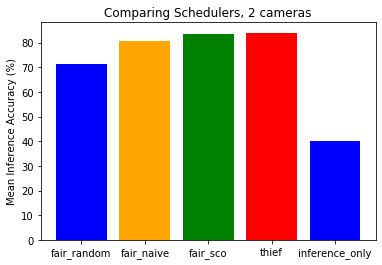

In [8]:
res = 5
plt.ylabel('Mean Inference Accuracy (%)')
plt.title('Comparing Schedulers, 2 cameras')
plt.bar(range(len(data[res])), list(data[res].values()), align='center',  color=['blue', 'orange', 'green', 'red'])
plt.xticks(range(len(data[res])), list(data[res].keys()))

<IPython.core.display.Javascript object>


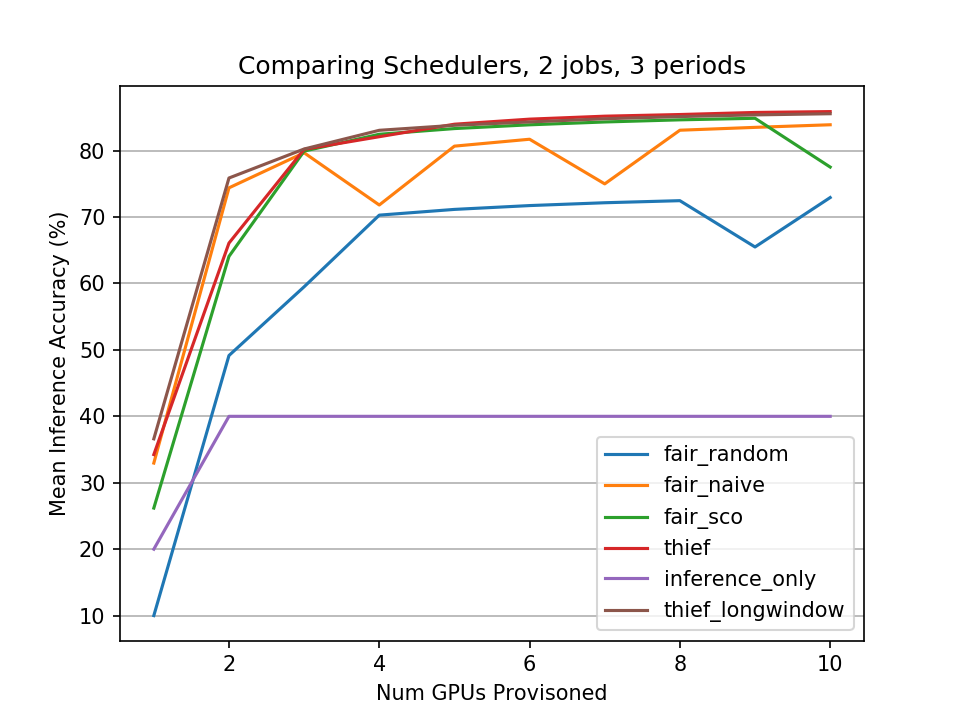

{'fair_random': {'res': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'acc': [10.0, 49.15457703349372, 59.505016331412065, 70.28908864452963, 71.15330614984596, 71.72902708338536, 72.15596704265612, 72.46692727868276, 65.49524222861767, 72.93684337040388]}, 'fair_naive': {'res': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'acc': [32.965016510513436, 74.39836294050785, 79.67885047861186, 71.81636812975553, 80.67652925731893, 81.71700857936945, 74.99615457075555, 83.07409569935481, 83.50433281900689, 83.8956794205025]}, 'fair_sco': {'res': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'acc': [26.189008911007278, 64.08031173869475, 79.92942478540569, 82.46457311373656, 83.32207010465532, 83.88881070420246, 84.31641894785524, 84.63796779774147, 84.87244753189465, 77.5263328697533]}, 'thief': {'res': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'acc': [34.24221960146635, 66.08287942162292, 80.19420774206458, 82.09908870527084, 83.97871641602764, 84.74194266251614, 85.1872955044379, 85.43625579797965, 85.7481309434424, 85.87742769824588]},

In [20]:
plt.figure()
scheduler_wise_data = {k: {"res": [], "acc": []} for k in data[1].keys()}
for res in data.keys():
    for sched in data[res].keys():
        scheduler_wise_data[sched]["res"].append(res)
        scheduler_wise_data[sched]["acc"].append(data[res][sched])
#scheduler_wise_data["thief"]["acc"][0] = 41
for sched in scheduler_wise_data:
    plt.plot(scheduler_wise_data[sched]["res"], scheduler_wise_data[sched]["acc"], label=sched)
plt.xlabel('Num GPUs Provisoned')
plt.ylabel('Mean Inference Accuracy (%)')
plt.title('Comparing Schedulers, 2 jobs, {} periods'.format(num_periods))
plt.legend()
plt.gca().yaxis.grid(True)

print(scheduler_wise_data)

In [10]:
data_instacp={'fair_worst': 29.690015550093747,
 'fair_smart': 50.643793494072995,
 'thief': 65.95741850672249,
 'inference_only': 15.000000000000002}

data_nocp={'fair_worst': 7.5,
 'fair_smart': 39.031395653312515,
 'thief': 51.776637679714945,
 'inference_only': 15.0}

combined_data = defaultdict(list)

combined_data = {k: [data[k], data_nocp[k]] for k in data.keys()}
print(combined_data)

KeyError: 1

In [ ]:
import numpy as np

labels = ['Always Checkpointing', 'EndOnly Checkpointing'] # [5, 30, 200], [150, 300, 200]

x = np.arange(len(labels))  # the label locations

num_bars = len(combined_data.keys())
width = 0.7/num_bars
x_pos = np.arange(-1*num_bars*width/2, num_bars*width/2, width)

fig, ax = plt.subplots()
for i, (label, values) in enumerate(combined_data.items()):
    ax.bar(x + x_pos[i], values, width, label=label, zorder=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Inference Accuracy (%)')
ax.set_title('Comparing Schedulers vs Checkpointing Method, 2 cameras')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center')

fig.tight_layout()
plt.grid(axis='y', zorder=0)

plt.show()

### Accuracy progression

In [ ]:
plt.figure()
for job, result in results.items():
    if job != 'meta':
        t, acc = list(zip(*result))
        plt.plot(t, acc, label=job.name)
plt.title("Training and inference job accuracy over time")
plt.legend()
plt.xlabel("Wall time")
plt.ylabel("Accuracy")

In [ ]:
for t, allocation in sim.period_allocation.items():
    names = []
    allocs = []
    for j, alloc in allocation.items():
        allocs.append(alloc)
        names.append(j.name)
    print(names, allocs)
    plt.figure()
    plt.pie(allocs, labels=names, autopct='%1.1f%%',
        shadow=True, startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title("Allocation at t = {}".format(t))

In [ ]:
means = []
for j, result in results.items():
    if isinstance(j, InferenceJob):
        mean_accuracy = sum(r[1] for r in result)/len(result)
        means.append(mean_accuracy)
MEAN_AUC = sum(means)/len(means)
print("Mean Inference Accuracy across all jobs: {}".format(MEAN_AUC))

In [ ]:
results['meta']